# Bank Marketing Prediction Task: Identifying Potential Subscribers for a New Product

## Overview

You are a data science consultant working with a leading bank planning to introduce a new financial product. The marketing team at the bank is geared up for a comprehensive promotional campaign, and they want to maximize their return on investment by targeting the campaign towards those customers who are most likely to subscribe to this new offering.

Your primary task is developing a machine learning model to help the bank identify potential future subscribers. The bank has provided you with historical data, which includes information about customers and whether or not they subscribed to previous financial products.

### Business Objectives

1. **Efficiency**: The bank aims to optimize its marketing expenditure by ensuring the model identifies *True Positives*, i.e., customers who are correctly identified as likely to subscribe. Every *False Positive* leads to an unnecessary cost for the bank.

2. **Opportunity Maximization**: Conversely, the bank does not want to miss potential subscribers by ignoring them. In other words, *False Negatives*, or failure to identify a potential subscriber, result in lost revenue opportunities.

**The challenge lies in balancing both these objectives. Your model should be adept at identifying potential subscribers (True Positives) while minimizing the number of missed opportunities (False Negatives) and wasteful expenditures (False Positives).**

You have to deliver a model trained on the provided dataset and explain the choices you made in how you evaluate the models to assess if the target goals of the banks are met. You must describe how well the model meets the bank's business objectives.

### Dataset - Bank Marketing (with social/economic context)

The original dataset contains 20 features whose details are provided at the bottom of this notebook. The final preprocessed dataset has been provided to you. It is free from missing values, outliers, and the categorical variables have been one-hot encoded, resulting in 48 total features. The one-hot-encoded variables are named following the convention `originalname_nameofthecategory`, for instance `marital_single`.

## Rules

Here are the rules that you need to follow:

- You have 1 hour and 15 minutes to complete the test. Once done, you must upload it on Sakai, as you did for the homework assignments.
- Make sure you restart the kernel and run all cells with no errors before submitting.
- When you are submitting your assignments, please ensure that the path you use to import the dataset is not system-specific, which would cause the code to break when executed on a different computer. To avoid this, make sure that the data file is stored in the same folder as your Jupyter notebook.
- Ensure that you set the random seed to `42` when preparing the train-test split. The test set size should be exactly 20% of the total dataset. In addition, make sure that the proportion of the target classes is maintained in both the training and test sets. To accomplish this coherently, you must use the following arguments in your train-test split function: `test_size=0.2, random_state=42` and choose the proper variable to `stratify`. Look at [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- Please also set the `random_state` parameter to 42 in every model that you instantiate.

Doc links of packages you may use are provided here: [pandas](https://pandas.pydata.org/docs/), [numpy](https://numpy.org/doc/stable/), [scikit-learn](https://scikit-learn.org/stable/), [xgboost](https://xgboost.readthedocs.io/en/stable/)

## Grading Rubric

- **Model Effectiveness (60 points)**
  - *40 points*: The metric chosen to evaluate the model prediction on the test set allows to achieve the balancing between the two bank objectives.
  - *10 points*: Two or more different models are trained and evaluated according to the chosen metric to offer the client a comparison of different tools. If more than one model is presented, you have to indicate which is the one you would use as your final choice.
  - *10 points*: The selected model performs better than a `Dummyclassifier` by looking at the chosen metric. You can import the DummyClassifier by running `from sklearn.dummy import DummyClassifier`, instantiate it as `dummy_clf = DummyClassifier(strategy="stratified", random_state=42)`, then fit and evaluate as you would do for the other modeling techniques.
  
- **Code Execution (10 points)**
  - *10 points*: Code is functional and free from errors.

- **Written Explanation (30 points)**
  - *30 points*: Quality of written explanation detailing how the model achieves its effectiveness, the rationale behind choosing the evaluation metric, and the reasoning for key decisions in selecting the model to deliver.
  
**Total: 100 points**

# Code Solution

In [ ]:
# Some empty cells are provided here but you can add more if you need it. Please delete the code that it is unncessary before submitting.

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

df = pd.read_csv("bank_marketing_encoded.csv")

X = df.copy()
y = X.pop("y")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)


In [96]:
def performance_evaluation_report(
    model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False
):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:
        if labels is None:
            labels = ["Negative", "Positive"]

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle("Performance Evaluation", fontsize=16)

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            linewidths=0.5,
            cmap="BuGn_r",
            square=True,
            cbar=False,
            ax=ax[0],
            annot_kws={"ha": "center", "va": "center"},
        )
        ax[0].set(
            xlabel="Predicted label", ylabel="Actual label", title="Confusion Matrix"
        )
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, "b-", label=f"ROC-AUC = {roc_auc:.2f}")
        ax[1].set(
            xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve"
        )
        ax[1].plot(
            fp / (fp + tn), tp / (tp + fn), "ro", markersize=8, label="Decision Point"
        )
        ax[1].plot([0, 1], [0, 1], "r--")
        ax[1].legend(loc="lower right")

        if show_pr_curve:
            ax[2].plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}")
            ax[2].set(
                xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve"
            )
            ax[2].legend()

    stats = {
        "accuracy": metrics.accuracy_score(y_test, y_pred),
        "precision": metrics.precision_score(y_test, y_pred),
        "recall": metrics.recall_score(y_test, y_pred),
        "specificity": (tn / (tn + fp)),
        "f1_score": metrics.f1_score(y_test, y_pred),
        "cohens_kappa": metrics.cohen_kappa_score(y_test, y_pred),
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
    }

    return stats

In [97]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)

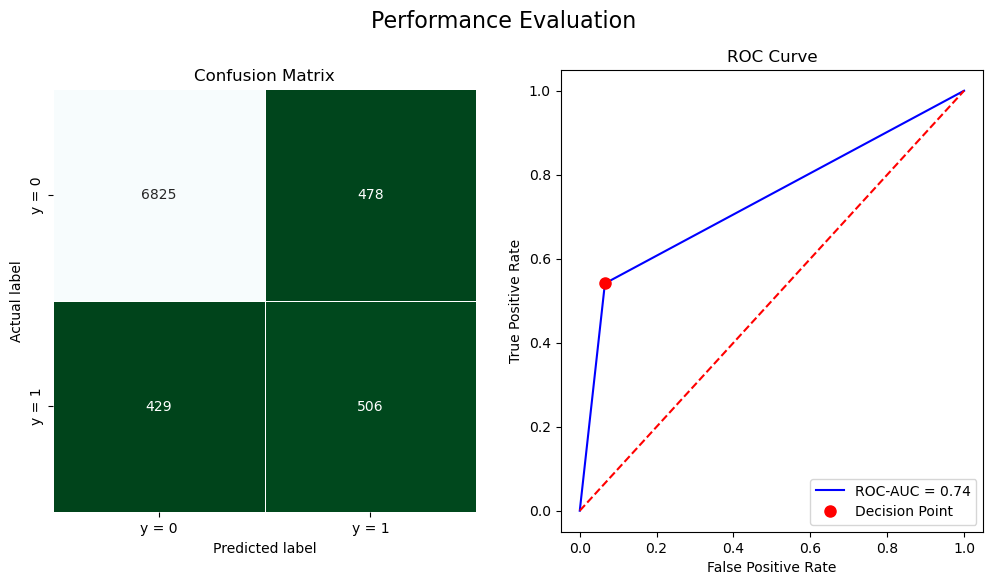

In [98]:
LABELS = ["y = 0", "y = 1"]
tree_perf = performance_evaluation_report(
    tree_classifier, X_test, y_test, labels=LABELS, show_plot=True
)

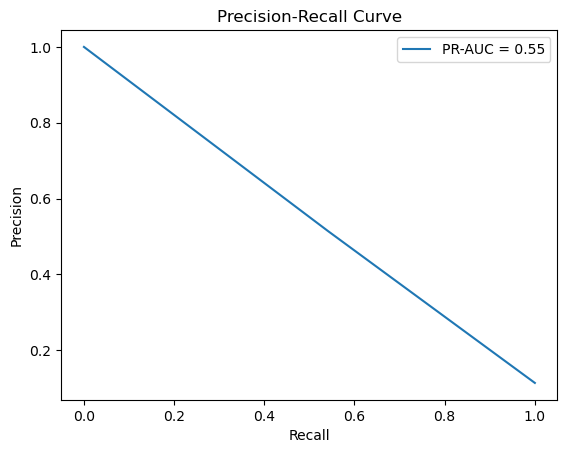

In [99]:
y_pred_prob = tree_classifier.predict_proba(X_test)[:,1]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
ax = plt.subplot()
ax.plot(recall, precision, label=f"PR-AUC = {metrics.auc(recall, precision):.2f}")
ax.set(title="Precision-Recall Curve", xlabel="Recall", ylabel="Precision")
ax.legend()

In [100]:
tree_perf["f1_score"]

0.5273579989577906

In [101]:
rf_classifier = RandomForestClassifier(
    n_estimators=100, max_features=10, n_jobs=-1, random_state=42
)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

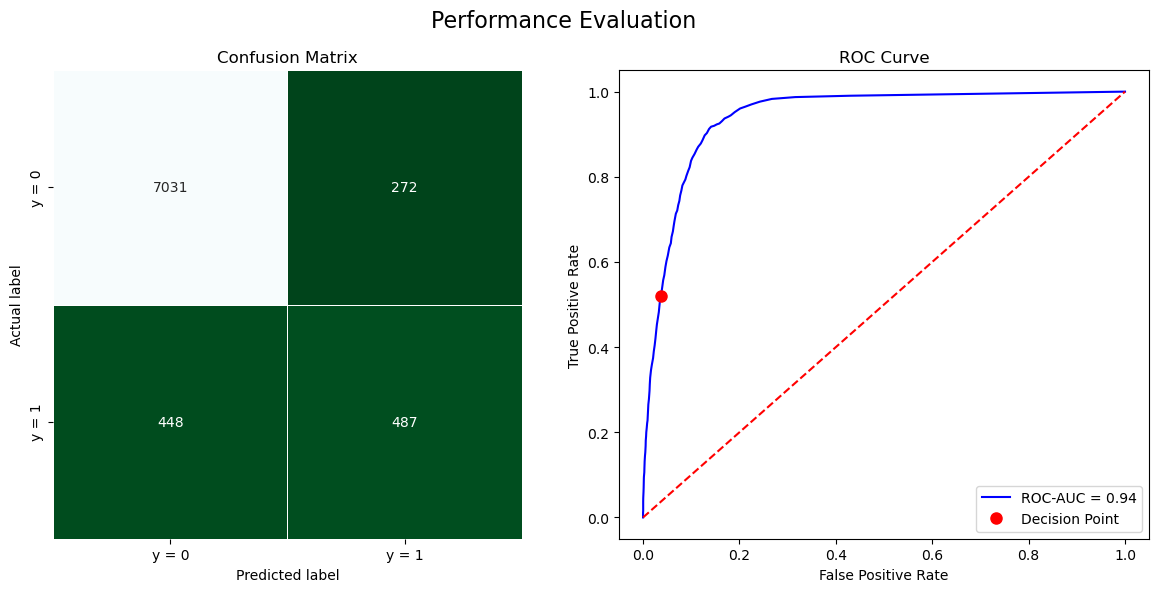

In [102]:
rf_perf = performance_evaluation_report(
    rf_classifier, X_test, y_test, labels=LABELS, show_plot=True
)

plt.tight_layout()

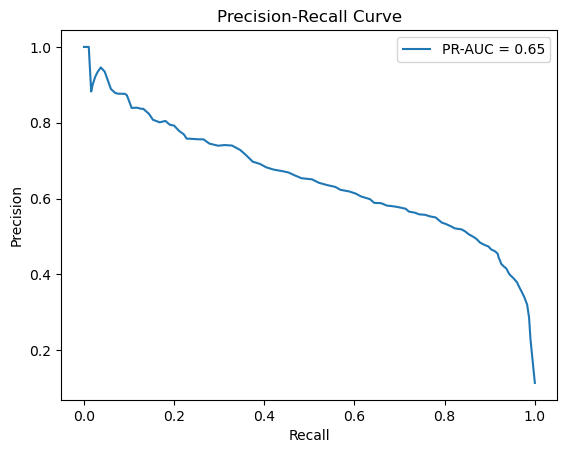

In [103]:
y_pred_prob = rf_classifier.predict_proba(X_test)[:,1]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
ax = plt.subplot()
ax.plot(recall, precision, label=f"PR-AUC = {metrics.auc(recall, precision):.2f}")
ax.set(title="Precision-Recall Curve", xlabel="Recall", ylabel="Precision")
ax.legend()

In [104]:
rf_perf["f1_score"]

0.5749704840613932

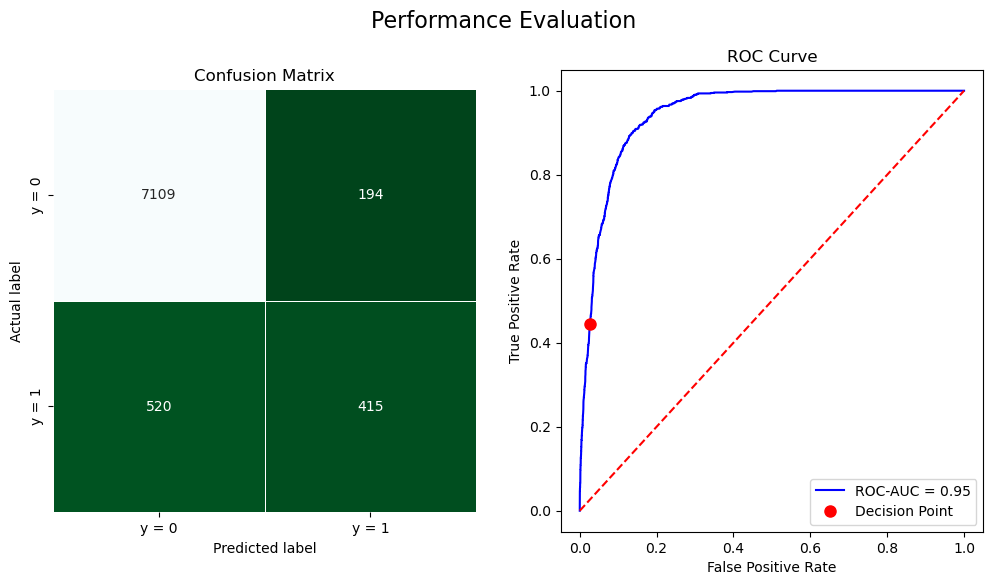

In [105]:
xgb_classifier = XGBClassifier(
    learning_rate=0.1, max_depth=3, n_estimators=50, random_state=0
)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

xgboost_perf = performance_evaluation_report(
    xgb_classifier, X_test, y_test, labels=LABELS, show_plot=True
)

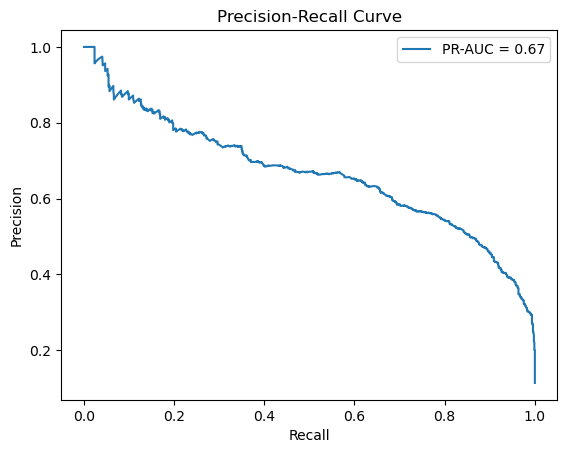

In [106]:
y_pred_prob = xgb_classifier.predict_proba(X_test)[:,1]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
ax = plt.subplot()
ax.plot(recall, precision, label=f"PR-AUC = {metrics.auc(recall, precision):.2f}")
ax.set(title="Precision-Recall Curve", xlabel="Recall", ylabel="Precision")
ax.legend()

In [107]:
xgboost_perf["f1_score"]

0.5375647668393783

In [108]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

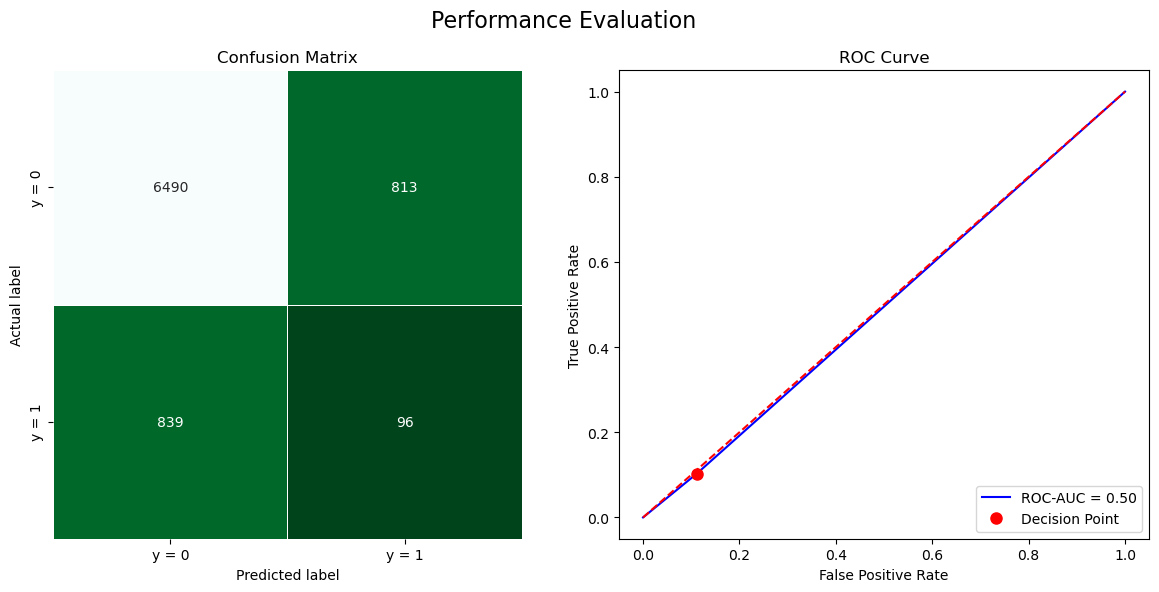

In [109]:
dummy_perf = performance_evaluation_report(
    dummy_clf, X_test, y_test, labels=LABELS, show_plot=True
)

plt.tight_layout()

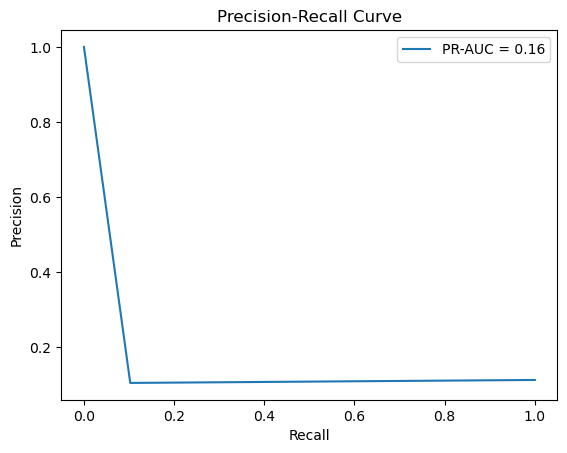

In [110]:
y_pred_prob = dummy_clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
ax = plt.subplot()
ax.plot(recall, precision, label=f"PR-AUC = {metrics.auc(recall, precision):.2f}")
ax.set(title="Precision-Recall Curve", xlabel="Recall", ylabel="Precision")
ax.legend()

In [111]:
dummy_perf["f1_score"]

0.10412147505422994

**Write in this markdown cell your comment on the operations you performed**:
I have split the dataset into train and test and first did the decision tree model. Then I did the Random Forest model. Then I did the XGBoost model. Finally I did Dummyclassifier model. I gained the Performance Evaluation and Precision-Recall Curve for all of these four models. 

The most important thing is I chose "F1Score" as the metric I would like to compare. The reason is that F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account, which meets the objectives of the bank. 

All of these three models perform better than dummyclassifier. The F1Score of dummyclassifier is 0.10412147505422994. For Decision Tree, the F1Score is 0.5273579989577906. For Random Forest, the F1Score is 0.5749704840613932. For XGBoost, the F1Score is 0.5375647668393783. Random Forest performs best. Thus, Random Forest would be my final choice.


# Dataset Features

**Bank Client Data**:
1. `age` (numeric)
2. `job`: Type of job (Categorical: Admin, Blue-collar, Entrepreneur, etc.)
3. `marital`: Marital status (Categorical: Divorced, Married, Single, etc.)
4. `education`: Education level (Categorical: Basic 4y, Basic 6y, Basic 9y, etc.)
5. `default`: Has credit in default? (Categorical: No, Yes, Unknown)
6. `housing`: Has housing loan? (Categorical: No, Yes, Unknown)
7. `loan`: Has personal loan? (Categorical: No, Yes, Unknown)

**Related to the Last Contact of the Current Campaign**:

8. `contact`: Contact communication type (Categorical: Cellular, Telephone)
9. `month`: Last contact month (Categorical: Jan, Feb, Mar, etc.)
10. `day_of_week`: Last contact day of the week (Categorical: Mon, Tue, Wed, etc.)
11. `duration`: Last contact duration, in seconds (Numeric)

**Other Attributes**:

12. `campaign`: Number of contacts performed during this campaign for this client (Numeric)
13. `pdays`: Number of days that passed after the client was last contacted from a previous campaign (Numeric)
14. `previous`: Number of contacts performed before this campaign for this client (Numeric)
15. `poutcome`: Outcome of the previous marketing campaign (Categorical: Failure, Nonexistent, Success)

**Social and Economic Context Attributes**:

16. `emp.var.rate`: Employment variation rate - Quarterly indicator (Numeric)
17. `cons.price.idx`: Consumer price index - Monthly indicator (Numeric)
18. `cons.conf.idx`: Consumer confidence index - Monthly indicator (Numeric)
19. `euribor3m`: Euribor 3-month rate - Daily indicator (Numeric)
20. `nr.employed`: Number of employees - Quarterly indicator (Numeric)

**Output Variable (Desired Target)**:
21. `y': Has the client subscribed to a term deposit? (Binary: Yes, No)

# Acknowledgements

Moro,S., Rita,P., and Cortez,P.. (2012). Bank Marketing. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001
